In [3]:
import os 
import sys
src_path = os.path.join(os.getcwd(), 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

In [4]:
import numpy as np

from onsite_modules.ScenarioManager import ScenarioManagerForReplay
from onsite_modules.ScenarioManager.ScenarioInfo import ScenarioInfo
from onsite_modules.recorder import Recorder
from planner import PLANNER

In [5]:
def check_action(dt, prev_v, prev_action, new_action):
    """检验选手返回的action是否满足动力学约束
    Args:
        dt: float, 时间间隔
        prev_v: float, 上一帧的速度
        prev_action: list, 上一帧的action
        new_action: list, 选手返回的action
    Returns:
        list, 满足动力学约束的action
    """
    ACC_LIMIT = 9.8         # m/s^2
    JERK_LIMIT = 49.0       # m/s^3
    ROT_LIMIT = 0.699       # rad
    ROT_RATE_LIMIT = 1.397  # rad/s

    checked_acc, checked_rot = new_action

    if not np.isnan(prev_action[0]):
        cur_v = prev_v + checked_acc * dt
        if cur_v < 0:
            # 如果时减速到停车的情况
            checked_acc = -prev_v / dt
        else:
            jerk = (new_action[0] - prev_action[0]) / dt
            if abs(jerk) > JERK_LIMIT:
                # 根据执行器动力学修正加速度
                jerk = np.clip(jerk, -JERK_LIMIT, JERK_LIMIT)
                checked_acc = prev_action[0] + jerk * dt

    if not np.isnan(prev_action[1]):
        rot_rate = (new_action[1] - prev_action[1]) / dt
        if abs(rot_rate) > ROT_RATE_LIMIT:
            # 根据执行器动力学修正前轮转角
            rot_rate = np.clip(rot_rate, -ROT_RATE_LIMIT, ROT_RATE_LIMIT)
            checked_rot = prev_action[1] + rot_rate * dt

    return [np.clip(checked_acc, -ACC_LIMIT, ACC_LIMIT), np.clip(checked_rot, -ROT_LIMIT, ROT_LIMIT)]


In [6]:
import math
import torch
import tensorflow as tf
import numpy as np 
from lxml import etree
from xml.dom.minidom import parse

import utils.pack_h5 as pack_utils
from onsite_modules.opendrive2discretenet.network import Network
from onsite_modules.opendrive2discretenet.opendriveparser.parser import parse_opendrive as parse_opendrive_xml

class AgentInfo:
    def __init__(self, id, name, type):
        self.id = id
        self.name = name
        self.type = type
        self.length = 0.0
        self.width = 0.0
        self.height = 0.0
        # t: [center_x, center_y, center_z, heading, velocity_x, velocity_y]
        self.traj = {}
    
    def set_ego_traj(self, x, y, h, v):
        v = abs(v)
        h = self._normalize_h(h)
        self.traj[0.0] = np.array([x, y, 0.0, h, v * math.cos(h), v * math.sin(h)])
    
    def set_other_traj(self, times, trajs):
        for time, traj in zip(times, trajs):
            self.traj[time] = traj
    
    # [center_x, center_y, center_z, length, width, height, heading, velocity_x, velocity_y, valid]
    def get_traj_info(self, start_time, end_time, dt = 0.1):
        trajs = []
        t = start_time
        while (t <= end_time):
            cur_state = self.traj.get(t, None)
            if cur_state is not None:
                trajs.append([
                    cur_state[0], cur_state[1], cur_state[2],
                    self.length, self.width, self.height,
                    cur_state[3], cur_state[4], cur_state[5], 1
                ])
            else:
                trajs.append([
                    0.0, 0.0, 0.0, self.length, self.width, self.height, 0.0, 0.0, 0.0, 0
                ])
            t += dt
        return trajs

    @staticmethod
    def _normalize_h(h):
        return ((h % (2 * math.pi)) + 2 * math.pi) % (2 * math.pi)

def extract_map_from_xodr(xodr_path):
    mf_id = []
    mf_xyz = []
    mf_type = []
    mf_edge = []
    id_map = {}

    with open(xodr_path, 'r', encoding='utf-8') as fh:
        root = etree.parse(fh).getroot()
    openDriveXml = parse_opendrive_xml(root)

    loadedRoadNetwork = Network()
    loadedRoadNetwork.load_opendrive(openDriveXml)

    for id, parametric_lane in enumerate(loadedRoadNetwork._planes):
        if parametric_lane.type == "driving":
            id_map[parametric_lane.id_] = id
            mf_id.append(id)

            discrete_lane = parametric_lane.to_discretelane()
            mf_xyz.append(
                np.concatenate((discrete_lane.center_vertices, 
                                np.zeros((discrete_lane.center_vertices.shape[0], 1))), axis=1)
            )
            mf_type.append(1)

    for id, parametric_lane in enumerate(loadedRoadNetwork._planes):
        if parametric_lane.type == "driving":
            successor = loadedRoadNetwork._link_index.get_successors(parametric_lane.id_)
            for old_id in successor:
                mf_edge.append([id, id_map.get(old_id, -1)])
    return mf_id, mf_xyz, mf_type, mf_edge

def extract_light_from_json():
    tl_lane_state = [[] for _ in range(11)]
    tl_lane_id = [[] for _ in range(11)]
    tl_stop_point = [[] for _ in range(11)]
    return tl_lane_state, tl_lane_id, tl_stop_point

def extract_agent_from_xosc(xosc_path):
    agents = {}

    opens = parse(xosc_path).documentElement
    objects = opens.getElementsByTagName('ScenarioObject')
    for idx, object_ in enumerate(objects):
        agent_name = object_.getAttribute("name")
        category_elements = object_.getElementsByTagName('Vehicle')
        if category_elements:
            agent_type = category_elements[0].getAttribute("vehicleCategory")
        else:
            agent_type = "pedestrian"
            
        agent = AgentInfo(idx, agent_name, agent_type)
        dimension_element = object_.getElementsByTagName('Dimensions')[0]
        for k, v in dimension_element.attributes.items():
            agent.__setattr__(k, float(v))

        agents[agent_name] = agent
        
    # 读取本车信息
    ego_node = opens.getElementsByTagName('Private')[0]
    ego_init = ego_node.childNodes[3].data
    ego_v, ego_x, ego_y, ego_head = [float(i.split('=')[1]) for i in ego_init.split(',')]
    agents['Ego'].set_ego_traj(ego_x, ego_y, ego_head, ego_v)

    # 读取背景车信息
    select_keys = ['x', 'y', 'z', 'h']
    acts = opens.getElementsByTagName('Act')
    for act in acts:
        agent_name = act.getAttribute("name").split('_')[-1]

        times = []
        trajs = []
        for status in act.getElementsByTagName('Vertex'):
            loc = status.getElementsByTagName('WorldPosition')[0]
            times.append(round(float(status.getAttribute('time')), 3))
            trajs.append([loc.getAttribute(key) for key in ['x', 'y', 'z', 'h']])
        
        times = np.array(times, dtype=float)
        trajs = np.array(trajs, dtype=float)
        trajs = np.concatenate([
                trajs[:-1], 
                (np.diff(trajs[:, 0]) / np.diff(times))[:, None], 
                (np.diff(trajs[:, 1]) / np.diff(times))[:, None]
            ], 
            axis=-1
        )
        agents[agent_name].set_other_traj(times, trajs)

    TYPES = ['car', 'pedestrian', 'bicycle']
    agent_id = []
    agent_type = []
    agent_role = []
    agent_states = []
    for agent in agents.values():
        agent_id.append(agent.id)
        agent_type.append(TYPES.index(agent.type))
        if agent.name == 'Ego':
            agent_role.append([True, False, False])
        else:
            agent_role.append([False, False, False])
        agent_states.append(agent.get_traj_info(0, 1))

    return agent_id, agent_type, agent_states, agent_role

def generate_batch_info(xodr_path, xosc_path, scenario_id):
    mf_id, mf_xyz, mf_type, mf_edge = extract_map_from_xodr(xodr_path)
    tl_lane_state, tl_lane_id, tl_stop_point = extract_light_from_json()
    agent_id, agent_type, agent_states, agent_role = extract_agent_from_xosc(xosc_path)

    N_PL_TYPE = 11
    DIM_VEH_LANES = [0, 1, 2]
    DIM_CYC_LANES = [3]
    DIM_PED_LANES = [4]

    N_TL_STATE = 5

    N_PL_MAX = 3000
    N_TL_MAX = 40
    N_AGENT_MAX = 1300

    N_PL = 1024
    N_TL = 100
    N_AGENT = 64
    N_AGENT_NO_SIM = 256

    THRESH_MAP = 500  # ! 120
    THRESH_AGENT = 120

    N_STEP = 91
    STEP_CURRENT = 10

    pack_all = False
    pack_history = True

    episode = {}
    n_pl = pack_utils.pack_episode_map(
        episode=episode, mf_id=mf_id, mf_xyz=mf_xyz, mf_type=mf_type, mf_edge=mf_edge, n_pl_max=N_PL_MAX
    )
    n_tl = pack_utils.pack_episode_traffic_lights(
        episode=episode,
        tl_lane_state=tl_lane_state,
        tl_lane_id=tl_lane_id,
        tl_stop_point=tl_stop_point,
        pack_all=pack_all,
        pack_history=pack_history,
        n_tl_max=N_TL_MAX,
        step_current=STEP_CURRENT,
    )
    n_agent = pack_utils.pack_episode_agents(
        episode=episode,
        agent_id=agent_id,
        agent_type=agent_type,
        agent_states=agent_states,
        agent_role=agent_role,
        pack_all=pack_all,
        pack_history=pack_history,
        n_agent_max=N_AGENT_MAX,
        step_current=STEP_CURRENT,
    )
    scenario_center, scenario_yaw = pack_utils.center_at_sdc(episode)

    episode_reduced = {}
    pack_utils.filter_episode_map(episode, N_PL, THRESH_MAP, thresh_z=5)
    episode_with_map = episode["map/valid"].any(1).sum() > 0
    pack_utils.repack_episode_map(episode, episode_reduced, N_PL, N_PL_TYPE)

    pack_utils.filter_episode_traffic_lights(episode)
    pack_utils.repack_episode_traffic_lights(episode, episode_reduced, N_TL, N_TL_STATE)

    mask_sim, mask_no_sim = pack_utils.filter_episode_agents(
        episode=episode,
        episode_reduced=episode_reduced,
        n_agent=N_AGENT,
        prefix="history/",
        dim_veh_lanes=DIM_VEH_LANES,
        dist_thresh_agent=THRESH_AGENT,
        step_current=STEP_CURRENT,
    )
    episode_reduced["map/boundary"] = pack_utils.get_map_boundary(
        episode_reduced["map/valid"], episode_reduced["map/pos"]
    )

    pack_utils.repack_episode_agents(episode, episode_reduced, mask_sim, N_AGENT, "history/")
    pack_utils.repack_episode_agents_no_sim(
        episode, episode_reduced, mask_no_sim, N_AGENT_NO_SIM, "history/"
    )

    n_step = 91
    n_step_history = 11
    n_agent = 64
    n_agent_no_sim = 256
    n_pl = 1024
    n_tl = 100
    n_tl_stop = 40
    n_pl_node = 20

    tensor_size_test = {
        # object_id for waymo metrics
        "history/agent/object_id": (n_agent,),
        "history/agent_no_sim/object_id": (n_agent_no_sim,),
        # agent_sim
        "history/agent/valid": (n_step_history, n_agent),  # bool,
        "history/agent/pos": (n_step_history, n_agent, 2),  # float32
        "history/agent/z": (n_step_history, n_agent, 1),  # float32
        "history/agent/vel": (n_step_history, n_agent, 2),  # float32, v_x, v_y
        "history/agent/spd": (n_step_history, n_agent, 1),  # norm of vel, signed using yaw_bbox and vel_xy
        "history/agent/acc": (n_step_history, n_agent, 1),  # m/s2, acc[t] = (spd[t]-spd[t-1])/dt
        "history/agent/yaw_bbox": (n_step_history, n_agent, 1),  # float32, yaw of the bbox heading
        "history/agent/yaw_rate": (n_step_history, n_agent, 1),  # rad/s, yaw_rate[t] = (yaw[t]-yaw[t-1])/dt
        "history/agent/type": (n_agent, 3),  # bool one_hot [Vehicle=0, Pedestrian=1, Cyclist=2]
        "history/agent/role": (n_agent, 3),  # bool [sdc=0, interest=1, predict=2]
        "history/agent/size": (n_agent, 3),  # float32: [length, width, height]
        "history/agent_no_sim/valid": (n_step_history, n_agent_no_sim),
        "history/agent_no_sim/pos": (n_step_history, n_agent_no_sim, 2),
        "history/agent_no_sim/z": (n_step_history, n_agent_no_sim, 1),
        "history/agent_no_sim/vel": (n_step_history, n_agent_no_sim, 2),
        "history/agent_no_sim/spd": (n_step_history, n_agent_no_sim, 1),
        "history/agent_no_sim/yaw_bbox": (n_step_history, n_agent_no_sim, 1),
        "history/agent_no_sim/type": (n_agent_no_sim, 3),
        "history/agent_no_sim/size": (n_agent_no_sim, 3),
        # map
        "map/valid": (n_pl, n_pl_node),  # bool
        "map/type": (n_pl, 11),  # bool one_hot
        "map/pos": (n_pl, n_pl_node, 2),  # float32
        "map/dir": (n_pl, n_pl_node, 2),  # float32
        "map/boundary": (4,),  # xmin, xmax, ymin, ymax
        # traffic_light
        "history/tl_lane/valid": (n_step_history, n_tl),  # bool
        "history/tl_lane/state": (n_step_history, n_tl, 5),  # bool one_hot
        "history/tl_lane/idx": (n_step_history, n_tl),  # int, -1 means not valid
        "history/tl_stop/valid": (n_step_history, n_tl_stop),  # bool
        "history/tl_stop/state": (n_step_history, n_tl_stop, 5),  # bool one_hot
        "history/tl_stop/pos": (n_step_history, n_tl_stop, 2),  # x,y
        "history/tl_stop/dir": (n_step_history, n_tl_stop, 2),  # dx,dy
    }

    batch = {
        "episode_idx": str(0),
        "scenario_id": scenario_id,
        "scenario_center": torch.Tensor([scenario_center]),
        "scenario_yaw": torch.Tensor(np.array([scenario_yaw])),
        "with_map": torch.Tensor([episode_with_map]),
    }
    for k, _size in tensor_size_test.items():
        batch[k] = torch.from_numpy(np.ascontiguousarray(episode_reduced[k]))[tf.newaxis]

    return batch


2024-09-03 20:48:07.008297: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-03 20:48:07.038909: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-03 20:48:07.653590: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [13]:
import pl_modules.waymo_motion as waymo_motion_module
from typing import Dict, List, Optional, Tuple, Union
import time
import copy
import hydra
from pytorch_lightning import LightningModule
import torch
import tensorflow as tf
from omegaconf import DictConfig
from torch import Tensor, nn
import wandb
from pathlib import Path
from collections import OrderedDict

from models.metrics.training import TrainingMetrics
from models.metrics.logging import ErrorMetrics, TrafficRuleMetrics
from models.modules.distributions import MyDist
from models.modules.action_head import ActionHead
from utils.traffic_rule_checker import TrafficRuleChecker
from utils.teacher_forcing import TeacherForcing
from utils.buffer import RolloutBuffer
from utils.rewards import DifferentiableReward
from utils.dynamics import Dynamics
from utils.vis_waymo import VisWaymo
from data_modules.waymo_post_processing import WaymoPostProcessing
from models.metrics.womd import WOMDMetrics
from utils.submission import SubWOMD
from utils.visualizer import Visualizer

from data_modules.wosac_post_processing import WOSACPostProcessing
from models.metrics.wosac import WOSACMetrics
from onsite_modules.observation import Observation
from utils.transform_utils import torch_pos2global, torch_rad2rot, torch_rad2global


class DeepLearningEnv():
    def __init__(self, ckpt_path, duration: int = 90) -> None:
        self.k_futures = 1
        self.step_current = 0
        self.step_start = 1
        self.step_end = duration

        self.observation = Observation()

        self.model = waymo_motion_module.WaymoMotion.load_from_checkpoint(ckpt_path)
        self.model.eval()

    def init(self, scene_info):
        # 使用vars()获取实例的所有属性名和对应的值  
        # instance_vars = vars(scene_info)  
        # for key, value in instance_vars.items():  
        #     print(f"{key}: {value}")

        origin_batch = generate_batch_info(
            xodr_path = scene_info.source_file['xodr'],
            xosc_path = scene_info.source_file['xosc'],
            scenario_id = scene_info.name
        )
        self.batch = self.model.pre_processing(origin_batch)

        input_dict = {k.split("input/")[-1]: v for k, v in self.batch.items() if "input/" in k}
        input_feature_dict = self.model.model.encode_input_features(**input_dict)
        
        latent_prior_dict = {k.split("latent_prior/")[-1]: v for k, v in self.batch.items() if "latent_prior/" in k}
        latent_prior_feature_dict = self.model.model.encode_input_features(**latent_prior_dict)
        latent_prior = self.model.model.latent_encoder(**latent_prior_feature_dict)
        latent_prior.repeat_interleave_(self.k_futures, 0)
        
        for k in ["valid", "vel", "acc", "yaw_rate", "pos", "yaw_bbox", "spd", "size"]:
            self.batch[f"agent/{k}"] = self.batch[f"history/agent/{k}"]

        self.deterministic = torch.zeros_like(self.batch["history/agent/valid"][:, 0])  # [n_batch, n_agent]
        self.deterministic = self.deterministic.repeat_interleave(self.k_futures, 0)  # [n_batch*k_futures, n_agent]
        self.deterministic[::self.k_futures] = True

        self.goal_valid = input_dict["agent_valid"].any(1)
        self.goal_valid = self.goal_valid.repeat_interleave(self.k_futures, 0)
        goal_pred = self.model.model.goal_manager.pred_goal(
            agent_type=self.batch["ref/agent_type"],
            map_type=self.batch["ref/map_type"],
            agent_state=self.batch["ref/agent_state"],
            **input_feature_dict,
        )
        goal_pred.repeat_interleave_(self.k_futures, 0)
        self.goal_sample = goal_pred.sample(self.deterministic)
        goal_log_probs = goal_pred.log_prob(self.goal_sample)

        self.rule_checker = TrafficRuleChecker(
            self.batch["map/boundary"].repeat_interleave(self.k_futures, 0),
            self.batch["map/valid"].repeat_interleave(self.k_futures, 0),
            self.batch["map/type"].repeat_interleave(self.k_futures, 0),
            self.batch["map/pos"].repeat_interleave(self.k_futures, 0),
            self.batch["map/dir"].repeat_interleave(self.k_futures, 0),
            self.batch["history/tl_stop/valid"].repeat_interleave(self.k_futures, 0),
            self.batch["history/tl_stop/pos"].repeat_interleave(self.k_futures, 0),
            self.batch["history/tl_stop/state"].repeat_interleave(self.k_futures, 0),
            self.batch["history/agent/type"].repeat_interleave(self.k_futures, 0),
            self.batch["history/agent/size"].repeat_interleave(self.k_futures, 0),
            None,  # ground truth goal
            self.goal_sample,  # pred dest
            enable_check_collided=False,
            enable_check_run_road_edge=False,
            enable_check_run_red_light=False,
            enable_check_passive=False,
        )

        self.features = {
            "map_valid": input_feature_dict["map_feature_valid"],
            "map_feature": input_feature_dict["map_feature"],
            "tl_valid": input_feature_dict["tl_feature_valid"],
            "tl_feature": input_feature_dict["tl_feature"],
            "agent_type": self.batch["sc/agent_type"],
            "agent_size": self.batch["sc/agent_size"],
            # gt states for overriding
            "agent_valid": self.batch["agent/valid"],
            "vel": self.batch["agent/vel"],
            "acc": self.batch["agent/acc"],
            "yaw_rate": self.batch["agent/yaw_rate"],
            "agent_state": torch.cat([self.batch["agent/pos"], self.batch["agent/yaw_bbox"], self.batch["agent/spd"]], dim=-1),
        }
        for k in self.features.keys():
            self.features[k] = self.features[k].repeat_interleave(self.k_futures, 0)
        mask_teacher_forcing = self.model.teacher_forcing_joint_future_pred.get(self.features["agent_valid"], self.model.current_epoch)

        # self.rollout_buffer = RolloutBuffer(
        #     step_start=self.step_start, step_end=self.step_end, step_current=self.model.hparams.time_step_current
        # )
        self.model.model.init(latent_prior, self.deterministic)
        self.model.dynamics.init(
            agent_valid=self.features["agent_valid"][:, self.step_current],
            agent_state=self.features["agent_state"][:, self.step_current],
            agent_type=self.features["agent_type"],
            agent_size=self.features["agent_size"],
            vel=self.features["vel"][:, self.step_current],
            acc=self.features["acc"][:, self.step_current],
            yaw_rate=self.features["yaw_rate"][:, self.step_current],
        )
        self.goal_feature = self.model.model.goal_manager.get_goal_feature(
            goal=self.goal_sample, as_state=self.model.dynamics.agent_state, map_feature=self.features["map_feature"]
        )
        self.observation.update_test_info(dt=scene_info.task_info['dt'])
        self._update_observation_agent()
        
    def update_frame(self, control_info):
        self._update_t_and_end()
        
        with torch.no_grad():
            self.step_current += 1
            # predict _step, given _step-1, using last observered tl_state
            step_tl = min(self.step_current - 1, self.features["tl_valid"].shape[1] - 1)

            if self.model.model.goal_manager.update_goal:
                self.goal_feature = self.model.goal_manager.get_goal_feature(
                    goal=self.goal_sample, as_state=self.model.dynamics.agent_state, map_feature=self.features["map_feature"]
                )
            
            mask_action_override = self.batch['ref/agent_role'][:, :, 0].clone()
            action_override = torch.zeros((self.batch['ref/agent_role'].shape[0], self.batch['ref/agent_role'].shape[1], 2), dtype=torch.float)
            action_override[mask_action_override] = torch.tensor(control_info, dtype=torch.float)
            
            state_new, valid_new, train_dict, vis_dict = self.model.forward(
                map_feature=self.features["map_feature"],
                map_valid=self.features["map_valid"],
                tl_feature=self.features["tl_feature"][:, step_tl],
                tl_valid=self.features["tl_valid"][:, step_tl],
                goal_feature=self.goal_feature,
                goal_valid=self.goal_valid,
                action_override=action_override,
                mask_action_override=mask_action_override,
                deterministic_action=self.deterministic,
                require_train_dict=True,
                require_vis_dict=True,
            )

            # check violations, kill agents if outside map, update self.dynamics.agent_valid
            # _gt_valid = None if _step >= self.features["agent_valid"].shape[1] else self.features["agent_valid"][:, _step]
            # EDIT: 防止主车被kill掉，对gt_valid进行限制
            _gt_valid = torch.zeros_like(self.batch['history/agent/valid'][:, 0]) if self.step_current >= self.features["agent_valid"].shape[1] else self.features["agent_valid"][:, self.step_current]
            _gt_valid[0, 0] = True
            
            _gt_state = None if self.step_current >= self.features["agent_valid"].shape[1] else self.features["agent_state"][:, self.step_current]
            violations = self.rule_checker.check(self.step_current, valid_new, state_new)
            self.model.dynamics.kill(violations, _gt_valid)
            self.goal_valid = self.model.model.goal_manager.disable_goal_reached(
                goal_valid=self.goal_valid,
                agent_valid=self.model.dynamics.agent_valid,
                dest_reached=violations["dest_reached"],
                goal_reached=violations["goal_reached"],
            )
        print(f"frame {self.step_current}: [acc={control_info[0]: .3f}, rot={control_info[1]: .3f}]")
        self._update_observation_agent()

    def close(self):
        pass

    def get_observation(self):
        return copy.deepcopy(self.observation)
    
    def _update_observation_agent(self):
        agent_attr = ["x", "y", "v", "a", "yaw", "length", "width"]
        agent_type_name = ["vehicle", "pedestrian", "bicycle"]
        
        agent_valid = self.model.dynamics.agent_valid
        agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
        agent_type = tf.argmax(self.model.dynamics.agent_type[agent_valid], axis=1)

        scenario_center = self.batch["scenario_center"].unsqueeze(1)
        scenario_rot = torch_rad2rot(self.batch["scenario_yaw"])
        agent_size = self.model.dynamics.agent_size[agent_valid][..., :2]
        agent_state = self.model.dynamics.agent_state[agent_valid]
        agent_acc = self.model.dynamics.acc[agent_valid]
        agent_yaw_rate = self.model.dynamics.yaw_rate[agent_valid]
        agent_pos = torch_pos2global(agent_state[..., :2], scenario_center, scenario_rot)[0]
        agent_yaw = torch_rad2global(agent_state[..., 2:3], self.batch["scenario_yaw"])
        agent_state = torch.cat((agent_pos, agent_state[..., 3:4], agent_acc, agent_yaw, agent_size), dim=-1)

        self.observation.update_ego_info(**dict(zip(agent_attr, agent_state[0].numpy())))
        self.observation.update_ego_info(rot=float(agent_yaw_rate[0]))
        self.observation.erase_object_info()
        for i in range(1, agent_id.shape[0]):
            category = agent_type_name[agent_type[i]]
            agent_name = str(int(agent_id[i]))
            agent_info = dict(zip(agent_attr, agent_state[i].numpy()))
            self.observation.update_object_info(category, agent_name, **agent_info)

    def _update_t_and_end(self):
        self.observation.test_info["t"] += self.observation.test_info["dt"]
        if (self.step_current > self.step_end):
            self.observation.update_test_info(end=1)
            

In [ ]:
CKPT_PATH = r"/home/gz0779601/codes/DataDriven_BehaviourModels/deep_learning_model/v1.0/checkpoints/2cti1q5z_v41.ckpt"

def run(mode_config: dict, planner: object, scene_info: ScenarioInfo) -> None:
    # 实例化回放测试流程控制模块
    env = DeepLearningEnv(ckpt_path=CKPT_PATH, duration=90)
    # 实例化测试记录模块
    recorder = Recorder()
    # 用于记录归控模块回传的控制信息
    action = [float('nan'), float('nan')]

    # 回放测试流程控制模块初始化，在observation中加载主车信息及测试环境信息
    env.init(scene_info)
    # 被测物根据场景信息进行初始化设置
    planner.init(scene_info.format())

    while True:
        # 记录当前测试信息
        recorder.record(action, env.get_observation())
        # 判断仿真是否还在进行中
        if env.observation.test_info['end'] != -1:
            # 如果仿真结束则输出记录的测试信息
            recorder.output(scene_info.output_path)
            # 结束仿真环境，导出rollout-buffer
            env.close()
            break
        # 如果仿真还在运行，则获取规控模块回传的控制信息
        action = planner.act(env.get_observation())
        # 对规控器回传的控制信息进行执行器动力学约束修正
        ego_action = check_action(
            dt = scene_info.task_info['dt'], 
            prev_v = env.observation.ego_info.v, 
            prev_action = [env.observation.ego_info.a, env.observation.ego_info.rot], 
            new_action = action
        )
        # 根据修正后的控制量更新主车位置
        env.update_frame(ego_action)


/tmp/ipykernel_127524/1336832687.py:297: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  "with_map": torch.Tensor([episode_with_map]),
/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


----------------------------LATTICE INIT----------------------------
frame 1: [acc=-0.192, rot=-0.000]


/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


frame 2: [acc=-0.192, rot=-0.000]
frame 3: [acc=-0.191, rot=-0.000]


/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0

frame 4: [acc=-0.190, rot=-0.000]
frame 5: [acc=-0.189, rot=-0.000]
frame 6: [acc=-0.188, rot=-0.000]


/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0

frame 7: [acc=-0.187, rot=-0.000]
frame 8: [acc=-0.186, rot=-0.000]


/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0

frame 9: [acc=-0.186, rot=-0.000]
frame 10: [acc=-0.185, rot=-0.000]


/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/_

frame 11: [acc=-0.184, rot=-0.000]
frame 12: [acc=-0.183, rot=-0.000]


/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0

frame 13: [acc=-0.182, rot=-0.000]
frame 14: [acc=-0.182, rot=-0.000]


/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


frame 15: [acc=-0.181, rot=-0.000]


/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


frame 16: [acc=-0.180, rot=-0.000]
frame 17: [acc=-0.179, rot=-0.000]


/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0

frame 18: [acc=-0.178, rot=-0.000]
frame 19: [acc=-0.178, rot=-0.000]


/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0

frame 20: [acc=-0.177, rot=-0.000]
frame 21: [acc=-0.176, rot=-0.000]


/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


frame 22: [acc=-0.175, rot=-0.000]
frame 23: [acc=-0.175, rot=-0.000]


/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0

frame 24: [acc=-0.174, rot=-0.000]
frame 25: [acc=-0.173, rot=-0.000]
frame 26: [acc=-0.172, rot=-0.000]


/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0

frame 27: [acc=-0.172, rot=-0.000]
frame 28: [acc=-0.171, rot=-0.000]
frame 29: [acc=-0.170, rot=-0.000]


/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0

frame 30: [acc=-0.169, rot=-0.000]
frame 31: [acc=-0.169, rot=-0.000]


/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0

frame 32: [acc=-0.168, rot=-0.000]
frame 33: [acc=-0.167, rot=-0.000]


/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


frame 34: [acc=-0.166, rot=-0.000]
frame 35: [acc=-0.166, rot=-0.000]


/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0

frame 36: [acc=-0.165, rot=-0.000]
frame 37: [acc=-0.164, rot=-0.000]


/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0

frame 38: [acc=-0.163, rot=-0.000]
frame 39: [acc=-0.163, rot=-0.000]


/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0

frame 40: [acc=-0.162, rot=-0.000]
frame 41: [acc=-0.161, rot=-0.000]


/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gz0779601/miniconda3/envs/traffic_bots/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0

frame 42: [acc=-0.161, rot=-0.000]
frame 43: [acc= 1.960, rot=-0.002]
frame 44: [acc= 1.960, rot=-0.002]
frame 45: [acc= 1.960, rot=-0.003]
frame 46: [acc= 1.960, rot=-0.003]
frame 47: [acc= 1.960, rot=-0.003]
frame 48: [acc= 1.960, rot=-0.003]
frame 49: [acc= 1.960, rot=-0.003]
frame 50: [acc= 1.960, rot=-0.003]
frame 51: [acc= 1.960, rot=-0.003]


/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/tmp/ip

frame 52: [acc= 1.960, rot=-0.003]
frame 53: [acc= 1.960, rot=-0.003]
frame 54: [acc= 1.960, rot=-0.004]
frame 55: [acc= 1.960, rot=-0.004]
frame 56: [acc= 1.254, rot=-0.004]
frame 57: [acc= 0.094, rot=-0.004]
frame 58: [acc= 0.094, rot=-0.004]
frame 59: [acc=-0.035, rot=-0.004]
frame 60: [acc=-0.112, rot=-0.004]
frame 61: [acc=-0.098, rot=-0.004]


/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/tmp/ip

frame 62: [acc=-0.244, rot=-0.004]
frame 63: [acc=-0.249, rot=-0.004]
frame 64: [acc=-0.383, rot=-0.004]
frame 65: [acc=-0.387, rot=-0.004]
frame 66: [acc=-0.453, rot=-0.004]
frame 67: [acc=-0.597, rot=-0.004]
frame 68: [acc=-0.594, rot=-0.003]
frame 69: [acc=-0.672, rot=-0.003]
frame 70: [acc=-0.673, rot=-0.003]
frame 71: [acc=-0.803, rot=-0.003]


/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/tmp/ip

frame 72: [acc=-0.818, rot=-0.003]
frame 73: [acc=-1.960, rot=-0.001]
frame 74: [acc=-1.960, rot=-0.001]


/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]


frame 75: [acc=-1.960, rot=-0.001]
frame 76: [acc=-1.960, rot=-0.001]
frame 77: [acc=-1.960, rot=-0.001]
frame 78: [acc=-1.960, rot=-0.001]
frame 79: [acc=-1.960, rot=-0.001]
frame 80: [acc=-1.960, rot=-0.001]


/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/tmp/ip

frame 81: [acc=-1.960, rot=-0.001]
frame 82: [acc=-1.960, rot=-0.001]
frame 83: [acc=-1.960, rot=-0.001]
frame 84: [acc=-1.960, rot=-0.001]
frame 85: [acc=-1.960, rot=-0.000]
frame 86: [acc=-1.960, rot=-0.000]


/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/tmp/ip

frame 87: [acc=-1.960, rot=-0.000]
frame 88: [acc=-1.960, rot=-0.000]
frame 89: [acc=-1.960, rot=-0.000]
frame 90: [acc=-1.960, rot=-0.000]
frame 91: [acc=-1.960, rot=-0.000]
frame 92: [acc=-1.960, rot=-0.000]


/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/tmp/ipykernel_127524/2348710495.py:201: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  agent_id = torch.range(0, 63, dtype=torch.int16)[tf.newaxis, :][agent_valid]
/tmp/ip

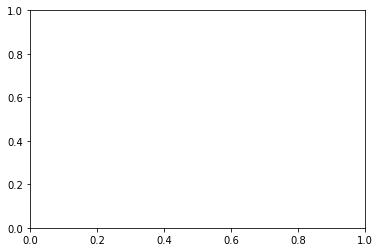

In [14]:

task_dir = r"./data/onsite_replay"
config = {
  "tasks": [],
  "visualize": False,
  "skipExist": True,
}
scenario_manager = ScenarioManagerForReplay(task_dir, config)

while scenario_manager.next():
    run(config, PLANNER(), scene_info=scenario_manager.cur_scene)
    break